In [126]:
import cv2
import skimage.io as io
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from scipy.signal import convolve2d
from statistics import mode,variance
from math import sqrt
from skimage.measure import find_contours
import matplotlib.pyplot as plt 
from skimage import data, color, img_as_ubyte 
from skimage.feature import canny 
from skimage.measure import label, regionprops
from skimage.transform import hough_ellipse 
from skimage.draw import ellipse_perimeter 
from skimage.draw import rectangle
from skimage.morphology import disk ,area_opening ,ball,closing
from skimage.morphology import rectangle as rec
from scipy.spatial.distance import euclidean
maxSpace=16

In [127]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [128]:
def verticalProj(img):
    imgTmp=np.ones((img.shape[0],img.shape[1]+4))
    imgTmp[:,2:imgTmp.shape[1]-2]=img
    img=imgTmp
    proj = np.sum(img,0)
    maxProjection = img.shape[0]-np.min(proj) 
    print(maxProjection)
    result = np.zeros(img.shape) 
    #Draw a line for each row 
    for col in range(img.shape[1]):
        result[0:int(proj[col]),col]=1 
    cv2.imwrite("outs/74.png",result*255)
    return result,maxProjection
def calcVerticalLinesPos(colHist,maxProjection):
    cv2.imwrite("outs/hist.png",colHist*255)
    n,m=colHist.shape
    thres=int(maxProjection*0.6)
    thres=colHist.shape[0]-thres-1
    start=end=0
    width=[]
    peaksMid=[]
    for i in range(m-1):
        if(colHist[thres][i]!=colHist[thres][i+1]):
            if colHist[thres][i]==1:
                #end of zeros
                start=i
            else:
                #end of ones
                end=i+1
                peaksMid.append(int((start+end)/2))
                width.append((end-start))
    
    return np.array(width),np.array(peaksMid)




In [129]:
def removeVerticalLines(imgOriginal,midPoint,curWidth):
    thresPixel=curWidth
    tmpWidth=curWidth
    curWidth=int(curWidth/2)+1
    errorThres=1
    for i in range(imgOriginal.shape[0]):
        #print(imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth])
        pixelSum= imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth].sum()
        pixelSum=(tmpWidth)-pixelSum
        #print(pixelSum,thresPixel,tmpWidth)
        if( pixelSum<=thresPixel):
            #print(imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth])
            imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth]=1
    return imgOriginal
def applyRemoving(width,peaksMids,img):
    for i in range(len(peaksMids)):
        img=removeVerticalLines(img,peaksMids[i],width[i])
    return img
        

In [130]:
def removeSymbolVerticalLines(contour):
    Binarized=contour
    result,maxProjection=verticalProj(Binarized)
    cv2.imwrite("outs/res.png",result*255)
    #print(maxProjection)
    width,peaksMids=calcVerticalLinesPos(result,maxProjection)
    #print(width,peaksMids)
    removedImg=applyRemoving(width,peaksMids,Binarized)
    cv2.imwrite("outs/removed.png",removedImg*255)
    return removedImg

In [131]:
def RemoveHorizontalAndDiagonalLines(img):
    removed = np.copy(img)
    labelImg = label(img)
    regions = regionprops(labelImg)
    diagonal = []
    for r in regions:
        minr, minc, maxr, maxc = r.bbox
        aspectratio = (maxc-minc)/(maxr-minr)
        if(aspectratio >= 1.5):
            diagonal.append([minr, minc, maxr, maxc])
            removed[minr:maxr,minc:maxc]=0
    count =0
    if len(diagonal)>0:
        count=1
        minr, minc, maxr, maxc = diagonal[0]
        col = (maxc+minc)/2
        for i in range (1,len(diagonal)):
            minr, minc, maxr, maxc = diagonal[i]
            if(minc < col and maxc > col):
                count+=1
        
    print(count)   
    return removed , count
    
        

In [132]:
def countBeamLines(img):
    diagonal = []
    tImg = np.copy(img)
    bLines = np.zeros(img.shape)
    removed = np.copy(img)
    img = img * 255
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    labelImg = label(tImg)
    regions = regionprops(labelImg)
    for r in regions:
        minr, minc, maxr, maxc = r.bbox
        aspectratio = (maxc-minc)/(maxr-minr)
        if(aspectratio >= 1.5):
            diagonal.append([minr, minc, maxr, maxc])
            bLines[minr:maxr,minc:maxc]=1
            removed[minr:maxr,minc:maxc]=0
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            y0,x0 = r.centroid
            ax.plot(bx, by, '-b', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=15)
            '''
            print("area : ",r.area)
            print("bounding box :" , r.bbox)
            print("width = " ,maxc-minc)
            print("height = ",maxr-minr)
            print("aspect ratio = ",((maxc-minc)/(maxr-minr)) )
            '''
    count =0
    if len(diagonal)>0:
        count=1
        minr, minc, maxr, maxc = diagonal[0]
        col = (maxc+minc)/2
        for i in range (1,len(diagonal)):
            minr, minc, maxr, maxc = diagonal[i]
            if(minc < col and maxc > col):
                count+=1
        
    print(count)   
    return removed , bLines
    
        

31.0


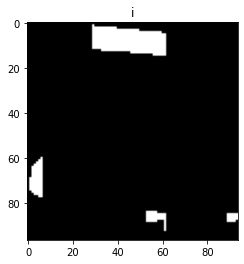

1


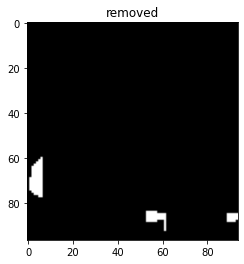

In [134]:
img2=cv2.imread("beam/8.",0)
img2=img2>100
img2=img2*1
removeSymbolVerticalLines(img2)
show_images([1-img2],["i"])

removed , count = RemoveHorizontalAndDiagonalLines(1-img2)
show_images([removed],["removed"])

In [121]:
import matplotlib.pyplot as plt
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import skimage.measure as measure
def testBlob(blob,index):
    width=blob.bbox[3]-blob.bbox[1]
    height=blob.bbox[2]-blob.bbox[0]
    print(width,height)
    minEccentricity=.2
    maxEccentricity=.9
    minArea=1.1*(maxSpace**2)
    maxArea=4*(maxSpace**2)
    minMajorAxis=maxSpace
    maxMajorAxis=3.2*maxSpace
    minMinorAxis=.5*maxSpace
    maxMinorAxis=2*maxSpace
    minSolidity=.85
    if( blob.solidity>=minSolidity and blob.area>minArea and blob.area<maxArea and blob.eccentricity <maxEccentricity and width>minMajorAxis and width<maxMajorAxis and height>minMinorAxis and height<maxMinorAxis):
        return True
    return False

def detectBlackBlob(symbol,index):
    labels = measure.label(symbol)
    props = measure.regionprops(labels)
    isBlob=False
    numBlobs=0
    for prop in props:
        isBlob=testBlob(prop,index)
        if(isBlob):
            numBlobs=numBlobs+1
    for prop in props:
        print(index,prop.area,prop.eccentricity,prop.major_axis_length,prop.minor_axis_length,prop.solidity)

    if(numBlobs>0):
        cv2.imwrite("blobs/"+str(index)+"_"+str(numBlobs)+".png",symbol*255)



In [124]:
img2=cv2.imread("outing.png",0)
img2=img2>100
img2=img2*1
contours = find_contours(img2, 0.8)
imgContours=[]
imgSymbolsContours=[]
index=0
for contour in contours:
    x = contour[:,1]
    y = contour[:,0]
    [Xmin, Xmax, Ymin, Ymax] = [np.amin(x), np.amax(x), np.amin(y), np.amax(y)]
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img2.shape)
    imgSymbol=img2[int(Ymin):int(Ymax+1),int(Xmin):int(Xmax+1)]
    imgContours.append([Ymin,Xmin])
    imgSymbol=removeSymbolVerticalLines(imgSymbol)
    imgSymbolsContours.append(1-imgSymbol)
    cv2.imwrite("contours/"+str(index)+".png",imgSymbol*255)
    index+=1
imgSymbolsContours=np.array(imgSymbolsContours)
imgContours=np.array(imgContours)

87.0
87.0
[6] [26]
96.0
96.0
[24] [29]
0.0
0.0
[] []
93.0
93.0
[7] [25]
14.0
14.0
[11] [10]
87.0
87.0
[6 6] [26 50]
87.0
87.0
[6] [25]
87.0
87.0
[6] [25]
395.0
395.0
[7] [15]
419.0
419.0
[5] [4]
13.0
13.0
[16] [10]
75.0
75.0
[5] [4]
75.0
75.0
[6] [5]
75.0
75.0
[7] [5]
75.0
75.0
[13] [8]
29.0
29.0
[ 5 11] [12 21]
15.0
15.0
[8 2] [10 15]
74.0
74.0
[6] [25]
74.0
74.0
[6] [26]
74.0
74.0
[6] [26]
86.0
86.0
[6 6] [25 85]
13.0
13.0
[11] [10]
14.0
14.0
[3 9] [ 6 12]
11.0
11.0
[11] [9]
75.0
75.0
[6] [25]
14.0
14.0
[9 2] [ 9 15]
0.0
0.0
[] []
14.0
14.0
[11] [9]
13.0
13.0
[9 2] [ 8 14]
1.0
1.0
[2] [3]
1.0
1.0
[2] [3]
15.0
15.0
[4 8] [ 7 13]
74.0
74.0
[6] [34]
39.0
39.0
[5] [3]
7.0
7.0
[3] [3]
29.0
29.0
[17] [18]
0.0
0.0
[] []
15.0
15.0
[3 8] [ 5 12]
0.0
0.0
[] []
0.0
0.0
[] []
4.0
4.0
[2] [2]
87.0
87.0
[6 5] [26 44]
111.0
111.0
[6] [25]
101.0
101.0
[7] [25]
96.0
96.0
[24] [29]
74.0
74.0
[6] [25]
74.0
74.0
[6] [25]
102.0
102.0
[6 6] [ 26 116]
107.0
107.0
[7 6 6 6] [ 33  78 122 166]
105.0
105.0
[6 

In [125]:
ind=0
for cont in imgSymbolsContours:
    detectBlackBlob(cont,ind)
    ind+=1

16 64
21 21
0 510 0.97347002393408 63.68079432120018 14.571094273633314 0.6864064602960969
0 367 0.573133540591136 24.068039100402128 19.722843093179375 0.976063829787234
15 55
7 29
1 10
5 18
1 417 0.9606483843135054 55.982015253676806 15.549974108991538 0.6847290640394089
1 153 0.961974091781292 27.56904582283724 7.5302287138500095 0.9807692307692307
1 10 1.0 11.489125293076057 0.0 1.0
1 68 0.9487559774768937 17.06044617029144 5.3912655234774585 0.9855072463768116
20 40
3 689 0.8823601701215654 44.7395837104869 21.05331532240471 0.9285714285714286
10 8
16 64
7 10
21 21
5 45 0.8572037863001783 11.606808131905707 5.977243268254435 0.9
5 484 0.9723635777182388 62.82979350508543 14.66898381690006 0.6549391069012178
5 56 0.7071565117700066 10.324244854558371 7.299830080456203 0.9655172413793104
5 367 0.573133540591136 24.068039100402128 19.722843093179375 0.976063829787234
17 64
20 21
6 508 0.9708925255819304 63.56212573184999 15.224118177539761 0.6512820512820513
6 359 0.5947730818459092 

92 127 0.8926014007577903 20.449987984060854 9.219809426748228 0.8819444444444444
92 98 0.9392492854578686 20.89783833411932 7.172885204517156 0.8448275862068966
2 12
2 6
94 24 0.9894548898363074 13.808210118138652 2.0 1.0
94 11 0.9518683762700559 6.410747983365109 1.9649396885733192 1.0
1 3
3 9
3 9
95 3 1.0 3.265986323710904 0.0 1.0
95 26 0.9470909899414479 10.03079444075773 3.2195358994696512 1.0
95 26 0.9470909899414479 10.030794440757731 3.2195358994696512 1.0
9 20
1 3
1 2
96 84 0.9297874352291504 20.513505315297653 7.550957645044726 0.7241379310344828
96 3 1.0 3.265986323710904 0.0 1.0
96 2 1.0 2.0 0.0 1.0
3 9
3 10
97 26 0.9470909899414479 10.030794440757731 3.2195358994696512 1.0
97 30 0.9587449708822046 11.489125293076057 3.265986323710904 1.0
